# Predicción Precio SPOT Diario España

El proyecto consiste en realizar un modelo de ML para la predicción del **Precio SPOT Diario España**. En este caso se tratara como un modelo de serie temporal, donde solo se utilizarán la variable datetime y el Precio mercado SPOT diario de España. Se tomará como base de partida el modelo realizado por **Shivagaje Pranav Ashok** para predecir la demanda de la electricidad desde la misma base de datos en el siguiente notebook: https://www.kaggle.com/code/shivagajepranav111a/daily-electricity-demand-forecast-machine-learning/notebook#Model-Building. A continuación, se describen las fases del proyecto:

- **Obtención de la base de datos**
- **Análisis y comprensión de la base de datos disponible**
- **Tratamiento de la base de datos**
- **Preparación de los datos para el entrenamiento**
- **Entrenamiento de los diferentes algoritmos**
- **Selección del modelo óptimo**


In [304]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_regression, mutual_info_regression
from termcolor import colored
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid




# 1. Obtención de la base de datos

La base de datos proviene del siguiente enlace de Kaggle: [Kaggle - Spanish Electricity Market Demand, Generation, and Price](https://www.kaggle.com/datasets/manualrg/spanish-electricity-market-demand-gen-price)

Según el creador:

> Este conjunto de datos es una serie temporal diaria que incluye la demanda de electricidad, la generación y los precios en España desde 2014 hasta 2018. Los datos provienen de ESIOS, un sitio web gestionado por REE (Red Eléctrica Española), que es el operador del sistema de transmisión (TSO) en España.

> La función principal de un TSO es operar el sistema eléctrico e invertir en nueva infraestructura de transmisión de alta tensión. Más información: [REE - Actividades de negocio en electricidad en España](https://www.ree.es/es/actividades).

> Como operador del sistema, REE pronostica la demanda y oferta de electricidad y gestiona las subastas diarias. Como resultado de estas subastas, se genera un PBF (Plan Básico de Funcionamiento), que es una programación básica de la producción de energía (sobre la cual se activan diversos mecanismos para asegurar el suministro).

> Los datos de energía y precios pueden descargarse en: [ESIOS](https://www.esios.ree.es/es).

> OMIE (Operador del Mercado Ibérico de Electricidad) es responsable de llevar a cabo estas subastas diarias y también ofrece información relevante. Más detalles: [OMIE](http://www.omie.es/).

### Variable de la base de datos que se va a utilizar

- **Precio mercado SPOT Diario ESP (€/MWh)**: Precio Diario del Mercado Spot en España


# 2. Análisis y comprensión de la base de datos

In [20]:
df=pd.read_csv('spain_energy_market.csv')
df=df[df['name']=='Precio mercado SPOT Diario ESP']
df.head(3)

,datetime,id,name,geoid,geoname,value
0,2014-01-01 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,25.280833
1,2014-01-02 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,39.924167
2,2014-01-03 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.992083


In [22]:
df.info()
df['datetime'] = pd.to_datetime(df['datetime'])

<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 0 to 1825
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  1826 non-null   object 
 1   id        1826 non-null   int64  
 2   name      1826 non-null   object 
 3   geoid     1826 non-null   float64
 4   geoname   1826 non-null   object 
 5   value     1826 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 99.9+ KB


## Conversión del dataframe para la columna `name` con el valor de `Precio mercado SPOT Diario ESP` en su columna

In [29]:
unique_names = df['name'].unique()


dataframes = {}


for name in unique_names:
    
    if not pd.isna(name):   
        safe_name = str(name).replace(" ", "_").replace("+", "plus").replace("/", "_")
        
    df_filtered = df[df['name'] == name]

    #print(df_filtered.head(3))
    
    dataframes[safe_name] = df_filtered

In [31]:
def juntar_df(dataframes):
    
    x=0
    for name, df in dataframes.items():
        df[name]=df['value']
        

        #print(df.head(3))
        df = df.drop(columns=['id','value','name','geoid','geoname'])
        #if name=='Energía_asignada_en_Mercado_SPOT_Diario_Francia':
            #print(df.head())
        if x==0:
            df_=df
            x=1
        else:
            df_=pd.merge(df_, df, on='datetime', how='outer')
    return df_

df_juntado=juntar_df(dataframes)
df_juntado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 0 to 1825
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   datetime                        1826 non-null   datetime64[ns]
 1   Precio_mercado_SPOT_Diario_ESP  1826 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 42.8 KB


# 3.Preparación de los datos para el entrenamiento

In [34]:
df_juntado.set_index("datetime", inplace=True)
df_juntado.info()
df=df_juntado.copy()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2014-01-01 23:00:00 to 2018-12-31 23:00:00
Data columns (total 1 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Precio_mercado_SPOT_Diario_ESP  1826 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


## Normalización de la variable target y creación de variables 

Se han creado las siguientes variables desde las que ya se tenían, de tal manera que se dispone de más información de los patrones estacionarios para el modelo de ML.

- **año**: 2014, 2015, 2016, 2017, 2018
- **trimestre**: El trimestre del año de forma numérica [1, 2, 3, 4]
- **mes**: El mes de forma numérica [1,2,3,4,5,6,7,8,9,10,11,12]
- **semana_año**: Se mana del año de forma numérica (del 1-52)
- **día_semana**: Día de la semana de forma numérica [1,2,3,4,5,6,7] 
- **ix**: Como si fuera un índice
- **movave_7**: Media de los últimos 7 días desde la propia fecha
- **movstd_7**: Desviación estandar de los útlimo 7 días desde la propia fecha
- **movave_30**: Media de los últimos 30 días desde la propia fecha
- **movstd_30**: Desviación estandar de los útlimo 30 días desde la propia fecha
- **movave_90**: Media de los últimos 90 días desde la propia fecha
- **movstd_90**: Desviación estandar de los útlimo 90 días desde la propia fecha
- **movave_365**: Media de los últimos 365 días desde la propia fecha
- **movstd_365**: Desviación estandar de los útlimo 365 días desde la propia fecha

Por otro lado, se ha normalizado la variable target del modelo.


C:\Users\PC\AppData\Local\Temp\ipykernel_8864\1943268380.py:9: FutureWarning: The provided callable <function mean at 0x0000023BCE3AA200> is currently using Rolling.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df[["movave_7", "movstd_7"]] = df.Precio_mercado_SPOT_Diario_ESP.rolling(7).agg([np.mean, np.std])
C:\Users\PC\AppData\Local\Temp\ipykernel_8864\1943268380.py:9: FutureWarning: The provided callable <function std at 0x0000023BCE3AA340> is currently using Rolling.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df[["movave_7", "movstd_7"]] = df.Precio_mercado_SPOT_Diario_ESP.rolling(7).agg([np.mean, np.std])
C:\Users\PC\AppData\Local\Temp\ipykernel_8864\1943268380.py:10: FutureWarning: The provided callable <function mean at 0x0000023BCE3AA200> is currently using Rolling.mean. In a future version o

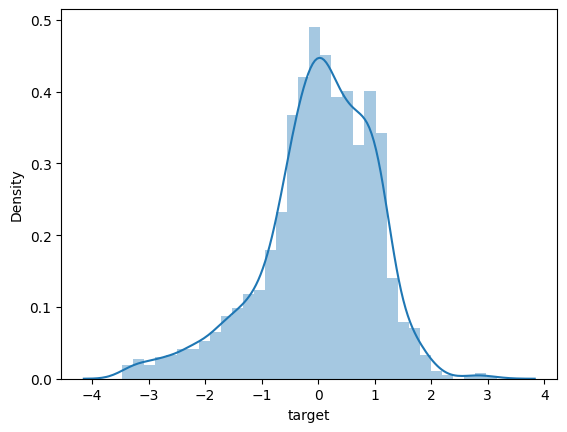

In [36]:
mean = np.mean(df.Precio_mercado_SPOT_Diario_ESP.values)
std = np.std(df.Precio_mercado_SPOT_Diario_ESP.values)
df["año"] = df.index.year
df["trimestre"] = df.index.quarter
df["mes"] = df.index.month
df["semana_año"] = df.index.isocalendar().week
df["día_semana"] = df.index.weekday
df["ix"] = range(0,len(df))
df[["movave_7", "movstd_7"]] = df.Precio_mercado_SPOT_Diario_ESP.rolling(7).agg([np.mean, np.std])
df[["movave_30", "movstd_30"]] = df.Precio_mercado_SPOT_Diario_ESP.rolling(30).agg([np.mean, np.std])
df[["movave_90", "movstd_90"]] = df.Precio_mercado_SPOT_Diario_ESP.rolling(90).agg([np.mean, np.std])
df[["movave_365", "movstd_365"]] = df.Precio_mercado_SPOT_Diario_ESP.rolling(365).agg([np.mean, np.std])

df["target"] = df.Precio_mercado_SPOT_Diario_ESP.add(-mean).div(std)
sns.distplot(df["target"])
plt.show()

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2014-01-01 23:00:00 to 2018-12-31 23:00:00
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Precio_mercado_SPOT_Diario_ESP  1826 non-null   float64
 1   año                             1826 non-null   int32  
 2   trimestre                       1826 non-null   int32  
 3   mes                             1826 non-null   int32  
 4   semana_año                      1826 non-null   UInt32 
 5   día_semana                      1826 non-null   int32  
 6   ix                              1826 non-null   int64  
 7   movave_7                        1820 non-null   float64
 8   movstd_7                        1820 non-null   float64
 9   movave_30                       1797 non-null   float64
 10  movstd_30                       1797 non-null   float64
 11  movave_90                       1737 non-null   float64
 12

## Generación de periodos

Se generan targets para cada periodo de 30 días, al igual que con las características.

In [68]:
features = []
corr_features=[]
targets = []
tau = 30 #forecasting periods

#para la generación de las target
for t in range(1, tau+1):
    df["target_t" + str(t)] = df.target.shift(-t)
    targets.append("target_t" + str(t))

# Para la generación de las características para cada periodo
for t in range(1,31):
    df["feat_ar" + str(t)] = df.target.shift(t)
    #df["feat_ar" + str(t) + "_lag1y"] = df.target.shift(350)
    features.append("feat_ar" + str(t))
    #corr_features.append("feat_ar" + str(t))
    #features.append("feat_ar" + str(t) + "_lag1y")
        
    
for t in [7, 14, 30]:
    df[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = df.Precio_mercado_SPOT_Diario_ESP.rolling(t).agg([np.mean, np.std, np.max, np.min])
    features.append("feat_movave" + str(t))
    #corr_features.append("feat_movave" + str(t))
    features.append("feat_movstd" + str(t))
    features.append("feat_movmin" + str(t))
    features.append("feat_movmax" + str(t))
    
# Generar las variables dummy para los meses y días de la semana
meses = pd.get_dummies(df.mes, prefix="mes", drop_first=True).astype(int)
dias = pd.get_dummies(df.día_semana, prefix="día_semana", drop_first=True).astype(int)

# Asegurarse de que los índices coincidan antes de la concatenación
meses.index = df.index
dias.index = df.index

# Concatenar las dummies con el DataFrame original
df = pd.concat([df, meses, dias], axis=1)
#display(df)
#display(meses)
# Actualizar la lista de features
features = features + meses.columns.values.tolist() + dias.columns.values.tolist()
#print(features)

C:\Users\PC\AppData\Local\Temp\ipykernel_8864\106729710.py:21: FutureWarning: The provided callable <function mean at 0x0000023BCE3AA200> is currently using Rolling.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = df.Precio_mercado_SPOT_Diario_ESP.rolling(t).agg([np.mean, np.std, np.max, np.min])
C:\Users\PC\AppData\Local\Temp\ipykernel_8864\106729710.py:21: FutureWarning: The provided callable <function std at 0x0000023BCE3AA340> is currently using Rolling.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = df.Precio_mercado_SPOT_Diario_ESP.rolling(t).agg([np.mean, np.std, np.max, np.min])
C:\Users\PC\AppDa

## Matriz de correlación

In [73]:
corr_features = ["feat_ar1", "feat_ar2", "feat_ar3", "feat_ar4", "feat_ar5", "feat_ar6", "feat_ar7", "feat_movave7", "feat_movave14", "feat_movave30"]

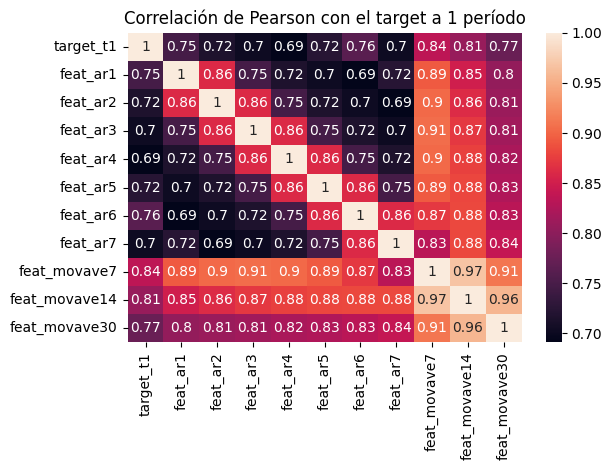

In [81]:
# Matriz de correlación
corr = df[["target_t1"] + corr_features].corr()

#Se eligen las 5 mejores
top5_mostCorrFeats = corr["target_t1"].apply(abs).sort_values(ascending=False).index.values[:6]

sns.heatmap(corr, annot=True)
plt.title("Correlación de Pearson con el target a 1 período")
plt.yticks(rotation=0); plt.xticks(rotation=90) 
plt.tight_layout()  

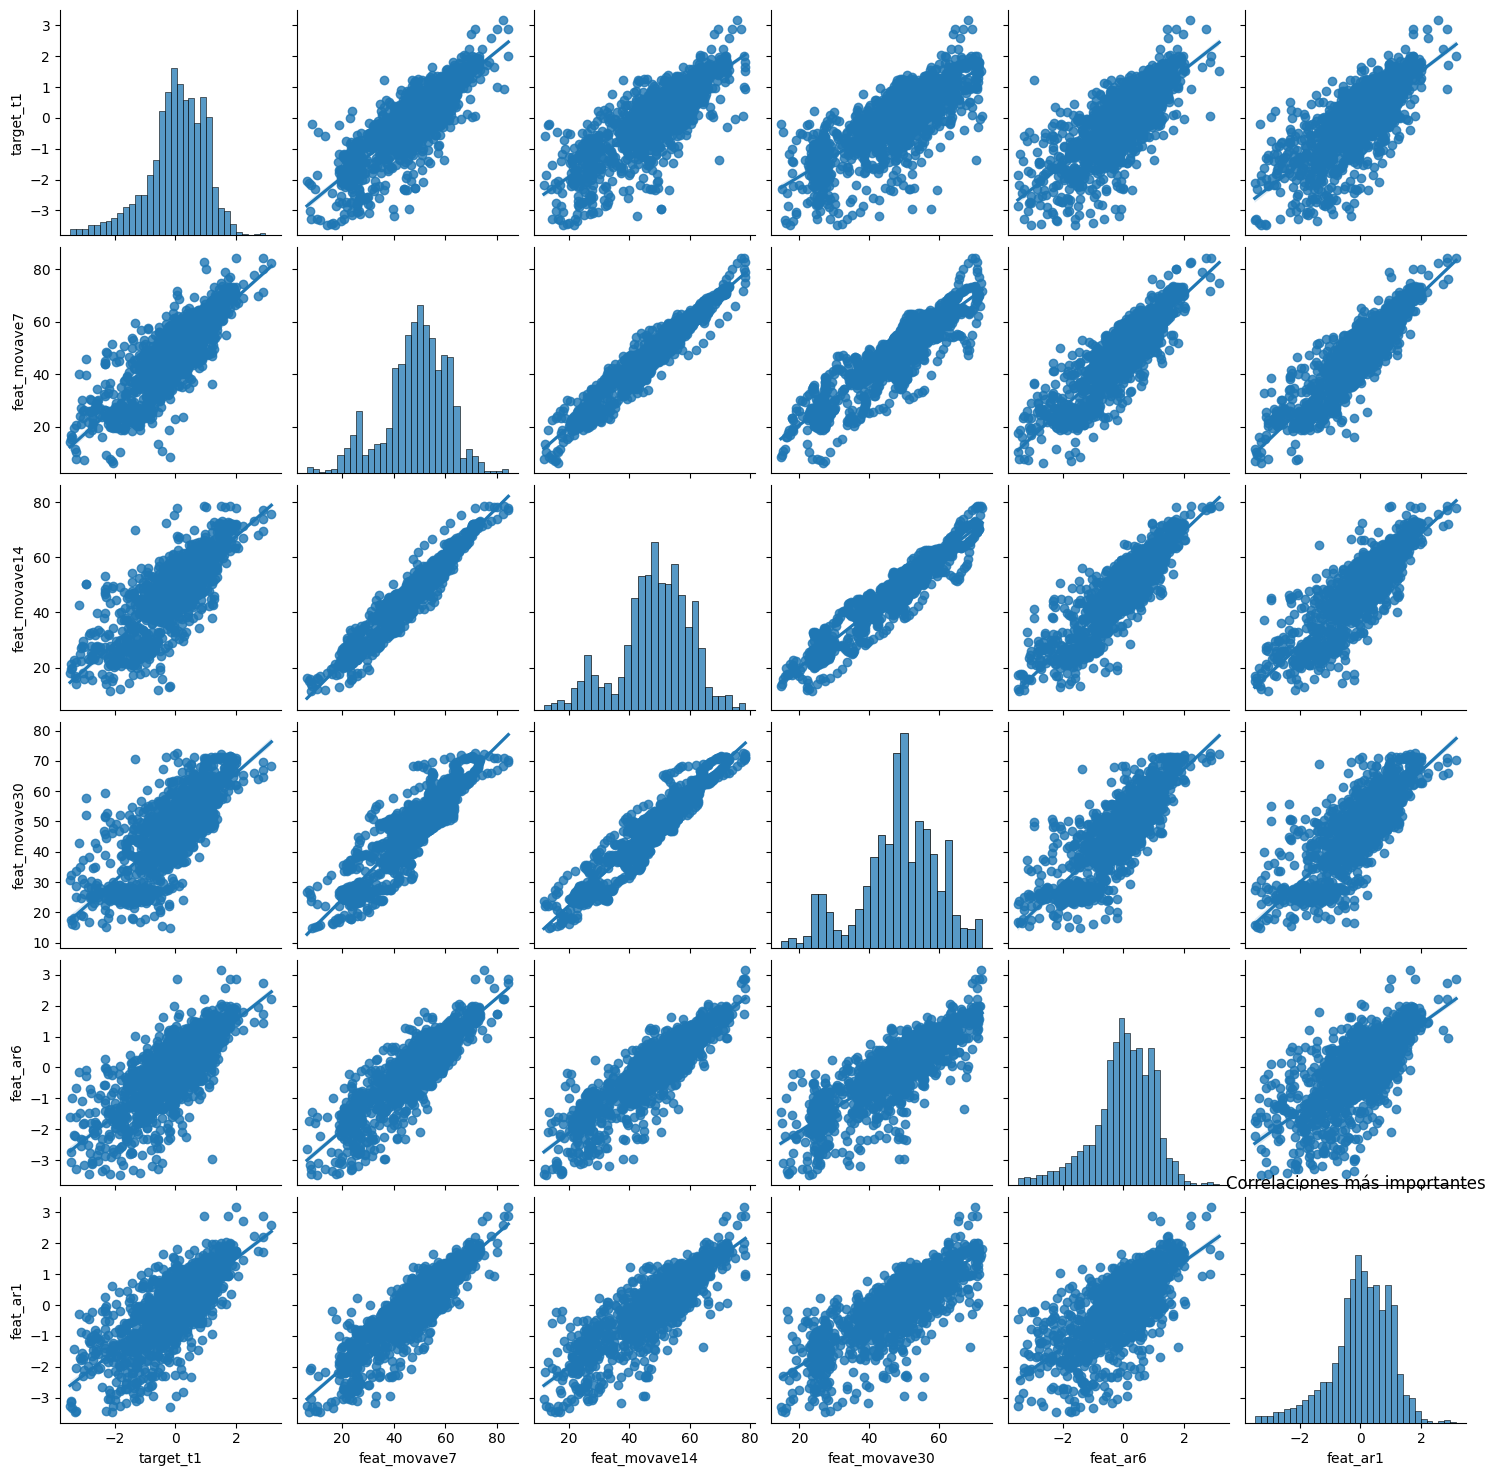

In [83]:
sns.pairplot(data=df[top5_mostCorrFeats].dropna(), kind="reg")
plt.title("Correlaciones más importantes")
plt.show()

In [148]:
df_feateng = df[features + targets].dropna()
nobs= len(df_feateng)
print("Número de observaciones: ", nobs)

Número de observaciones:  1766


## Train/test split (test último año)

Para realizar el test con valores más cercanos a la fecha, se separan los datos siendo los de test los de 2018. De tal manera que se intenta manetener una separación de 80/20.

Total number of observations:  1766
Train: (1431, 110) (1431, 30) 81.03057757644395, 
Test: (335, 110) (335, 30) 18.96942242355606


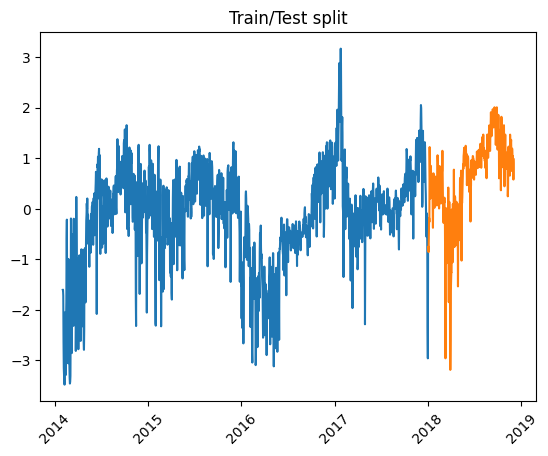

In [151]:
X_train = df_feateng.loc["2014":"2017"][features]
y_train = df_feateng.loc["2014":"2017"][targets]

X_test = df_feateng.loc["2018"][features]
y_test = df_feateng.loc["2018"][targets]

n, k = X_train.shape
print("Total number of observations: ", nobs)
print("Train: {} {} {}, \nTest: {} {} {}".format(X_train.shape, y_train.shape,len(X_train)/nobs*100,
                                              X_test.shape, y_test.shape,len(X_test)/nobs*100))

plt.plot(y_train.index, y_train.target_t1.values, label="train")
plt.plot(y_test.index, y_test.target_t1.values, label="test")
plt.title("Train/Test split")
plt.xticks(rotation=45)
plt.show()

In [153]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Random Forest Regressor

In [156]:
rf = RandomForestRegressor().fit(X_train, y_train["target_t1"])

p_train = rf.predict(X_train)
p_test = rf.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train["target_t1"], p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test["target_t1"], p_test))

MAPE_train = mean_absolute_percentage_error(y_train["target_t1"], p_train)
MAPE_test = mean_absolute_percentage_error(y_test["target_t1"], p_test)

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test))
print("Train MAPE: {:.2f}%\nTest MAPE: {:.2f}%".format(MAPE_train, MAPE_test))

Train RMSE: 0.1732531608769536
Test RMSE: 0.5164430601585939
Train MAPE: 166.76%
Test MAPE: 405.86%


### Linear Regression

In [158]:
reg = LinearRegression().fit(X_train, y_train["target_t1"])
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train["target_t1"], p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test["target_t1"], p_test))

MAPE_train = mean_absolute_percentage_error(y_train["target_t1"], p_train)
MAPE_test = mean_absolute_percentage_error(y_test["target_t1"], p_test)

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test))
print("Train MAPE: {:.2f}%\nTest MAPE: {:.2f}%".format(MAPE_train, MAPE_test))

Train RMSE: 0.38536576768314984
Test RMSE: 0.367468080376079
Train MAPE: 381.74%
Test MAPE: 166.32%


## Time series split

Consiste en realizar una validación cruzada con 3 splits, respetando el orden de los datos.

TRAIN: 360 TEST: 357


C:\Users\PC\AppData\Local\Temp\ipykernel_8864\1764449547.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][train_index].plot()
C:\Users\PC\AppData\Local\Temp\ipykernel_8864\1764449547.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][val_index].plot()


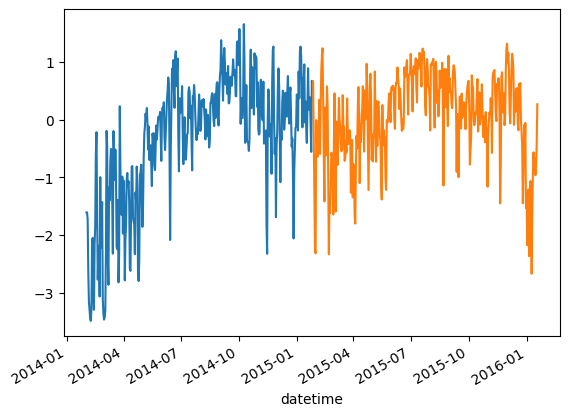

TRAIN: 717 TEST: 357


C:\Users\PC\AppData\Local\Temp\ipykernel_8864\1764449547.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][train_index].plot()
C:\Users\PC\AppData\Local\Temp\ipykernel_8864\1764449547.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][val_index].plot()


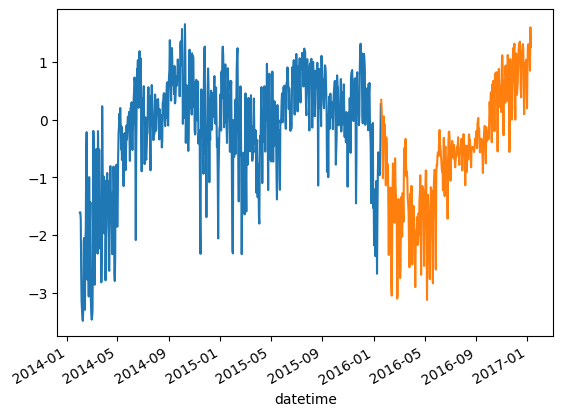

TRAIN: 730 TEST: 357


C:\Users\PC\AppData\Local\Temp\ipykernel_8864\1764449547.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][train_index].plot()
C:\Users\PC\AppData\Local\Temp\ipykernel_8864\1764449547.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][val_index].plot()


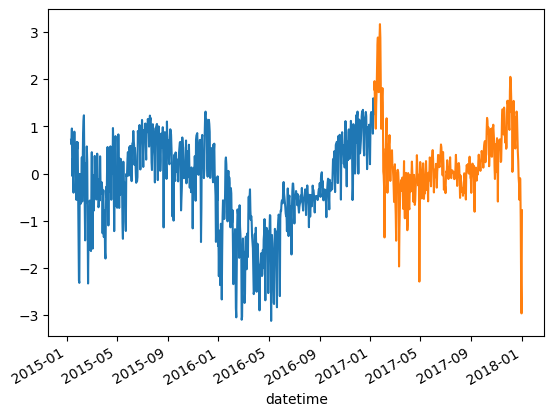

In [165]:
splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
for train_index, val_index in splits.split(X_train):
    print("TRAIN:", len(train_index), "TEST:", len(val_index))
    y_train["target_t1"][train_index].plot()
    y_train["target_t1"][val_index].plot()
    plt.show()

### Random Forest

In [199]:
splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
rfr = RandomForestRegressor()

# Diccionario de hiperparámetros
rfr_grid = {
    "n_estimators": [500], 
    'max_depth': [3, 5, 10, 20, 30], 
    'max_features': [4, 8, 16, 32, 59], 
    'random_state': [123]
}
rfr_paramGrid = ParameterGrid(rfr_grid)

def TimeSplit_ModBuild(model, paramGrid, splits, X, y):
    # Bucle sobre cada división de tiempo
    for train_index, val_index in splits.split(X_train):
        _X_train_ = X.iloc[train_index]
        _y_train_ = y.iloc[train_index]
        _X_val_ = X.iloc[val_index]
        _y_val_ = y.iloc[val_index]

        train_scores = []
        val_scores = []
        train_mape_scores = []
        val_mape_scores = []

        # Bucle a través de la grid de parámetros
        for g in paramGrid:
            model.set_params(**g)
            model.fit(_X_train_, _y_train_)
            p_train = model.predict(_X_train_)
            p_val = model.predict(_X_val_)
            
            # RMSE
            score_train = np.mean(mean_squared_error(_y_train_, p_train))
            score_val = np.mean(mean_squared_error(_y_val_, p_val))
            train_scores.append(score_train)
            val_scores.append(score_val)
            
            # MAPE
            train_mape = mean_absolute_percentage_error(_y_train_, p_train)
            val_mape = mean_absolute_percentage_error(_y_val_, p_val)
            train_mape_scores.append(train_mape)
            val_mape_scores.append(val_mape)

            # Encontrar el índice de la mejor puntuación
            best_idx = np.argmin(val_scores)
            
        print("Best-Fold HyperParams:: ", paramGrid[best_idx])
        print("Best-Fold Train RMSE: ", train_scores[best_idx])
        print("Best-Fold Val RMSE: ", val_scores[best_idx])
        print("Best-Fold Train MAPE: ", train_mape_scores[best_idx])
        print("Best-Fold Val MAPE: ", val_mape_scores[best_idx])
        print("\n")
        
    return train_scores, val_scores, train_mape_scores, val_mape_scores, best_idx

train_scores, val_scores, train_mape_scores, val_mape_scores, best_rfr_idx = TimeSplit_ModBuild(rfr, rfr_paramGrid, splits, X_train, y_train["target_t1"])


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 32, 'max_depth': 10}
Best-Fold Train RMSE:  0.05184501282472727
Best-Fold Val RMSE:  0.2949070202071529
Best-Fold Train MAPE:  0.6815485056702586
Best-Fold Val MAPE:  1.701396546147241


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 32, 'max_depth': 20}
Best-Fold Train RMSE:  0.03833890025498211
Best-Fold Val RMSE:  0.1899678996442663
Best-Fold Train MAPE:  0.6465169117593629
Best-Fold Val MAPE:  1.4669237706287572


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 16, 'max_depth': 30}
Best-Fold Train RMSE:  0.023607951981846217
Best-Fold Val RMSE:  0.25900630985414014
Best-Fold Train MAPE:  0.8914661449016944
Best-Fold Val MAPE:  18.810796705017307




In [275]:
best_rfr_grid = rfr_paramGrid[best_rfr_idx]
best_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train.loc["2016":"2017"], y_train.loc["2016":"2017", "target_t1"])

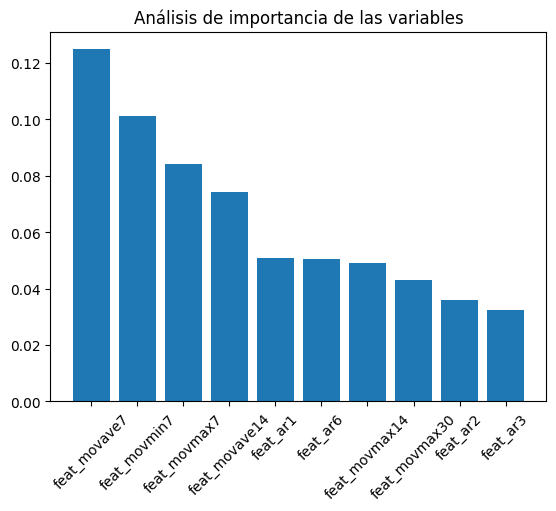

In [276]:
importances = best_rfr.feature_importances_

sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:10]
x = range(len(sorted_index_top))

labels = np.array(features)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Análisis de importancia de las variables")
plt.xticks(rotation=45)
plt.show()

In [277]:
p_train = best_rfr.predict(X_train)
train_resid_1step = y_train["target_t1"]- p_train

p_test = best_rfr.predict(X_test)
test_resid_1step = y_test["target_t1"]- p_test

In [278]:
test_df = y_test[["target_t1"]]*std+mean
test_df["pred_t1"] = p_test*std+mean
test_df["resid_t1"] = test_df["target_t1"].add(-test_df["pred_t1"])
test_df["abs_resid_t1"] = abs(test_df["resid_t1"])
test_df["ape_t1"] = test_df["resid_t1"].div(test_df["target_t1"])

test_MAPE = test_df["ape_t1"].mean()*100
print("MAPE del pronóstico a 1 periodo: ", test_MAPE)

MAPE del pronóstico a 1 periodo:  -3.1121527236461506


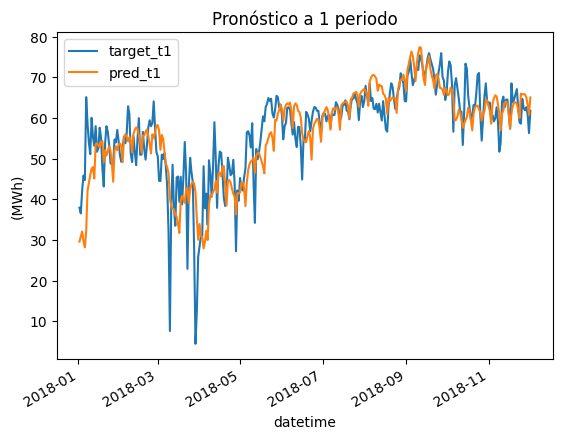

In [281]:
test_df[["target_t1", "pred_t1"]].plot()

plt.title("Pronóstico a 1 periodo")
plt.ylabel("(MWh)")
plt.legend()
plt.show()

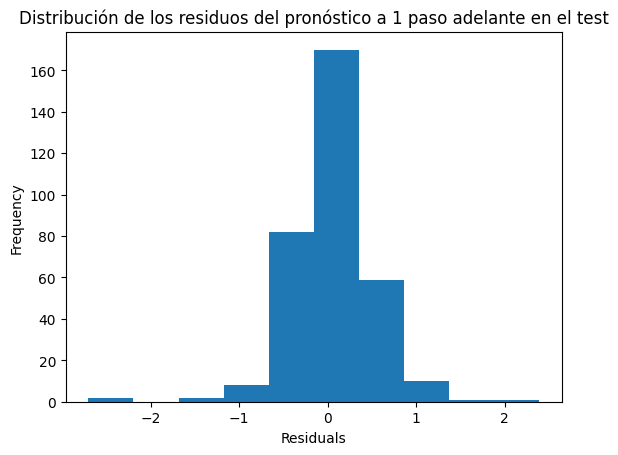

In [285]:
test_resid_1step.plot.hist(bins=10, title="Distribución de los residuos del pronóstico a 1 paso adelante en el test")
plt.xlabel("Residuals")
plt.show()

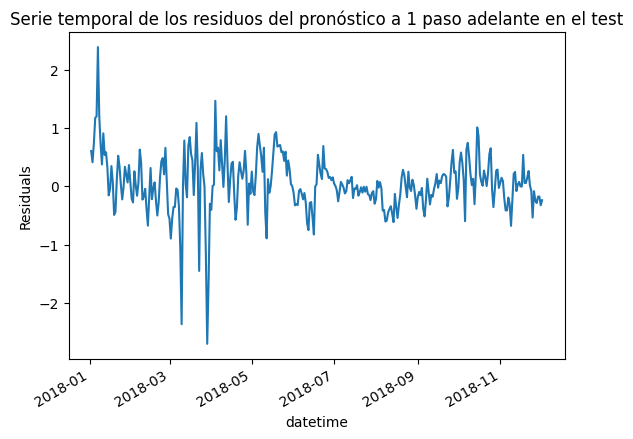

In [287]:
test_resid_1step.plot(title="Serie temporal de los residuos del pronóstico a 1 paso adelante en el test")
plt.ylabel("Residuals")
plt.show()

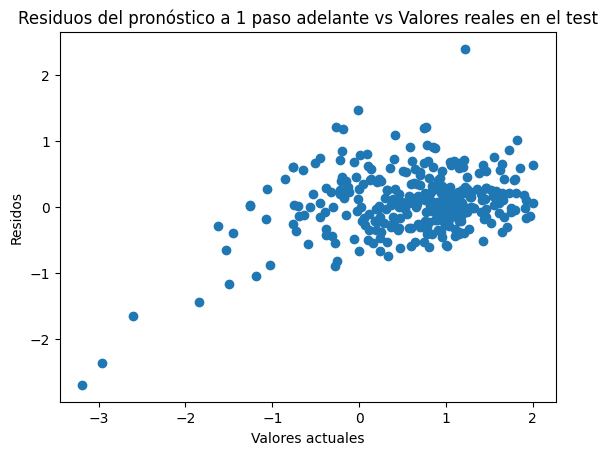

In [289]:
plt.scatter(x=y_test["target_t1"].values, y=test_resid_1step.values)
plt.title("Residuos del pronóstico a 1 paso adelante vs Valores reales en el test")
plt.ylabel("Residos")
plt.xlabel("Valores actuales")
plt.show()

In [291]:
multi_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train.loc["2016":"2017"], y_train.loc["2016":"2017"])

In [292]:
p_train = multi_rfr.predict(X_train)
train_resid_1step = y_train- p_train

p_test = multi_rfr.predict(X_test)
test_resid_1step = y_test- p_test

In [293]:
periods = [1, 7, 14, 30]

ytest_df = y_test*std+mean
ptest_df = pd.DataFrame(data=p_test*std+mean, index=test_df.index, columns=["pred_t" + str(i) for i in range(1, 31)])
test_df = pd.concat([ytest_df, ptest_df], axis=1)

test_MAPE = []

for t in periods:
    test_df["resid_t" + str(t)] = test_df["target_t" + str(t)].add(-test_df["pred_t" + str(t)])
    test_df["abs_resid_t" + str(t)] = abs(test_df["resid_t" + str(t)])
    test_df["ape_t" + str(t)] = test_df["abs_resid_t" + str(t)].div(test_df["target_t" + str(t)])
    test_MAPE.append(round(test_df["ape_t" + str(t)].mean(), 4)*100)
    
test_MAPE = [float(mape) for mape in test_MAPE]

print("MAPE test: ", test_MAPE)

MAPE test:  [12.97, 15.14, 16.869999999999997, 25.83]


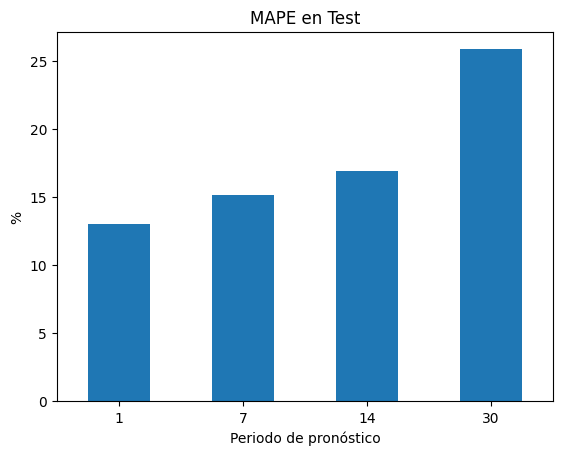

In [294]:
mape_df = pd.DataFrame(index=periods, data={"test_MAPE": test_MAPE})
mape_df.plot(kind="bar", legend=False)
plt.title("MAPE en Test")
plt.xlabel("Periodo de pronóstico")
plt.ylabel("%")
plt.xticks(rotation=0)
plt.show()

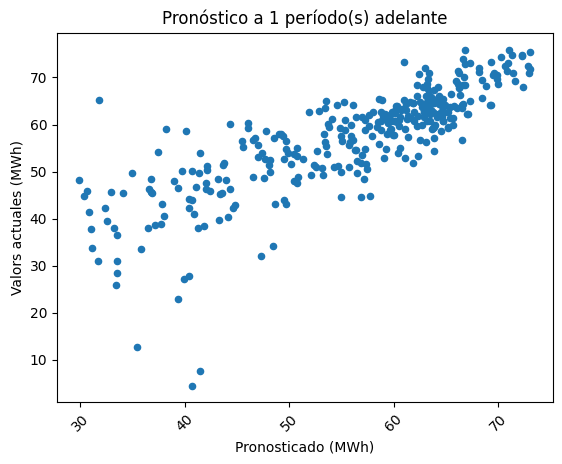

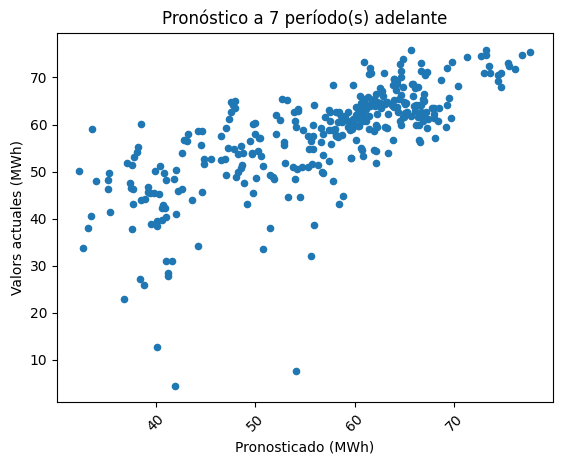

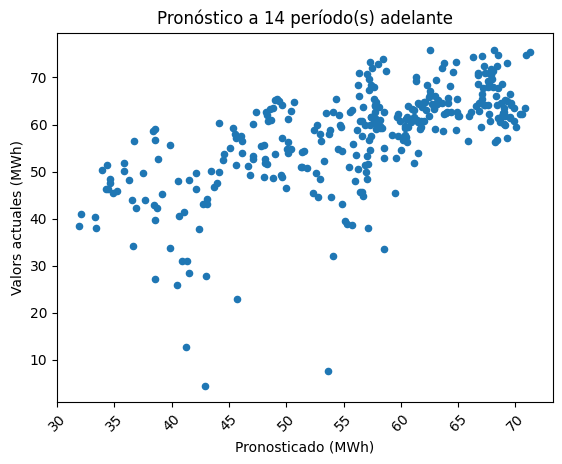

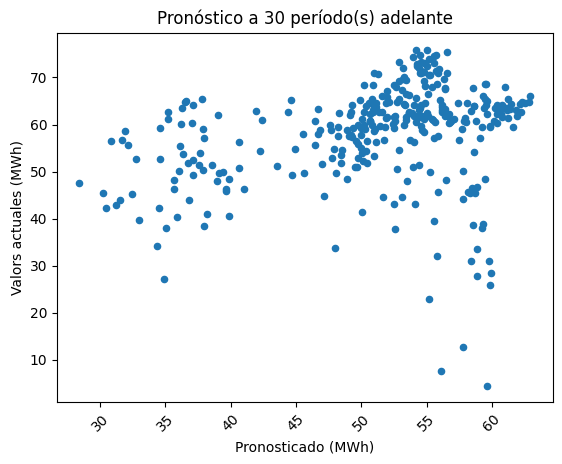

In [295]:
#f, ax = plt.subplots(nrows=3,ncols=2)
for t in periods:
    test_df[["target_t" + str(t), "pred_t" + str(t)]].plot(x="pred_t" + str(t), y="target_t" + str(t) ,kind="scatter")
    plt.title("Pronóstico a {} período(s) adelante".format(t))
    plt.xlabel("Pronosticado (MWh)")
    plt.ylabel("Valors actuales (MWh)")
    plt.xticks(rotation=45)
    plt.show()

Como era de esperar, el modelo es más preciso cuanto más cercana sea la predcción.